# **Exploratory Data Analysis**

---
---

**Data dictionary & problem description:**

Problem: predicting, based on measurements of contaminants collected over a year, whether it may be harmful to health or not.

- FECHA. Date recorded at the time of taking pollutant values (numeric)
- N_CCAA. Name of each autonomous community in Spain where measurement data for each pollutant has been collected (categorical)
- PROVINCIA. Name of each province where measurement data for each pollutant has been collected (categorical)
- N_MUNICIPIO. Name of each municipality where measurement data for each pollutant has been collected (categorical)
- ESTACION. Number assigned to each station of each autonomous community that has recorded pollutant measurement data (numeric)
- MAGNITUD. Each pollutant that has been recorded in the different stations (categorical)
- LATITUD, LONGITUD. Geographic data of each station where the pollutants have been recorded (numeric)
- H01, H02, H03... H24. Recorded value per hour of each pollutant. All contaminants have been taken with unified measurement units (µg/m3)(numeric) 

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import zipfile
from pickle import dump
import pickle

In [81]:
pd.set_option('display.max_columns', None)

In [82]:
clean_df = pd.read_csv('../data/processed/clean_pollutants.csv')
clean_df.head()

,FECHA,N_CCAA,PROVINCIA,N_MUNICIPIO,ESTACION,MAGNITUD,TIPO_AREA,TIPO_ESTACION,LATITUD,LONGITUD,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
0,2022-01-04,PAÍS VASCO,ÁLAVA,VITORIA-GASTEIZ,8,C6H6,URBANA,TRAFICO,42.8548,-2.6807,0.16,0.16,0.18,0.18,0.14,0.15,0.22,0.18,0.16,0.18,0.18,0.13,0.17,0.11,0.17,0.18,0.19,0.25,0.25,0.28,0.25,0.20,0.20,0.22
1,2022-01-05,PAÍS VASCO,ÁLAVA,VITORIA-GASTEIZ,8,C6H6,URBANA,TRAFICO,42.8548,-2.6807,0.23,0.26,0.22,0.20,0.21,0.23,0.28,0.31,0.34,0.40,0.35,0.29,0.27,0.30,0.48,0.33,0.45,0.58,0.57,0.51,0.51,0.51,0.48,0.41
2,2022-01-06,PAÍS VASCO,ÁLAVA,VITORIA-GASTEIZ,8,C6H6,URBANA,TRAFICO,42.8548,-2.6807,0.36,0.31,0.32,0.33,0.32,0.33,0.33,0.37,0.54,0.45,0.37,0.32,0.30,0.28,0.30,0.26,0.29,0.36,0.43,0.32,0.32,0.30,0.30,0.28
3,2022-01-07,PAÍS VASCO,ÁLAVA,VITORIA-GASTEIZ,8,C6H6,URBANA,TRAFICO,42.8548,-2.6807,0.25,0.24,0.25,0.26,0.32,0.32,0.28,0.25,0.30,0.27,0.30,0.39,0.28,0.23,0.28,0.29,0.28,0.32,0.31,0.23,0.25,0.29,0.29,0.28
4,2022-01-08,PAÍS VASCO,ÁLAVA,VITORIA-GASTEIZ,8,C6H6,URBANA,TRAFICO,42.8548,-2.6807,0.25,0.25,0.23,0.23,0.32,0.29,0.23,0.28,0.55,0.34,0.36,0.28,0.27,0.27,0.25,0.20,0.23,0.25,0.25,0.23,0.20,0.22,0.22,0.19


In [83]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719282 entries, 0 to 719281
Data columns (total 34 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FECHA          719282 non-null  object 
 1   N_CCAA         718259 non-null  object 
 2   PROVINCIA      719282 non-null  object 
 3   N_MUNICIPIO    718259 non-null  object 
 4   ESTACION       719282 non-null  int64  
 5   MAGNITUD       719282 non-null  object 
 6   TIPO_AREA      715747 non-null  object 
 7   TIPO_ESTACION  715747 non-null  object 
 8   LATITUD        715747 non-null  float64
 9   LONGITUD       715747 non-null  float64
 10  H01            719282 non-null  float64
 11  H02            719282 non-null  float64
 12  H03            719282 non-null  float64
 13  H04            719282 non-null  float64
 14  H05            719282 non-null  float64
 15  H06            719282 non-null  float64
 16  H07            719282 non-null  float64
 17  H08            719282 non-nul

### **1. Define the target**

In [84]:
# Lista de columnas de las cuales quieres calcular la media
columnas_h = [col for col in clean_df.columns if col.startswith('H')]

# Calcular la media de esas columnas para cada fila
clean_df['Media_Diaria'] = clean_df[columnas_h].mean(axis=1)

In [85]:
# Función para clasificar los valores de peligrosidad de cada contaminante
def clasificar_peligrosidad(valor, umbrales):
    if valor < umbrales['bajo']:
        return 'Baja'
    elif valor < umbrales['alto']:
        return 'Normal'
    else:
        return 'Alta'

# Aplicar la función a cada fila del DataFrame
def clasificar_fila(row):
    contaminante = row['MAGNITUD']
    valor = row['Media_Diaria']
    if contaminante in umbrales_peligrosidad:
        return clasificar_peligrosidad(valor, umbrales_peligrosidad[contaminante])

# Supongamos que estos son tus umbrales de peligrosidad definidos para 8 contaminantes
umbrales_peligrosidad = {
    'SO2': {'bajo': 25, 'alto': 40},
    'CO': {'bajo': 2, 'alto': 4},
    'C6H6': {'bajo': 2, 'alto': 5},
    'NO2': {'bajo': 15, 'alto': 25},
    'PM2.5': {'bajo': 10, 'alto': 15},
    'PM10': {'bajo': 25, 'alto': 45}, 
    'NOX': {'bajo': 75, 'alto': 100},
    'O3': {'bajo': 75, 'alto': 100}
}

# Crear una nueva columna con la clasificación de peligrosidad
clean_df['Peligrosidad'] = clean_df.apply(clasificar_fila, axis=1)

clean_df.head(3)

,FECHA,N_CCAA,PROVINCIA,N_MUNICIPIO,ESTACION,MAGNITUD,TIPO_AREA,TIPO_ESTACION,LATITUD,LONGITUD,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,Media_Diaria,Peligrosidad
0,2022-01-04,PAÍS VASCO,ÁLAVA,VITORIA-GASTEIZ,8,C6H6,URBANA,TRAFICO,42.8548,-2.6807,0.16,0.16,0.18,0.18,0.14,0.15,0.22,0.18,0.16,0.18,0.18,0.13,0.17,0.11,0.17,0.18,0.19,0.25,0.25,0.28,0.25,0.20,0.20,0.22,0.187083,Baja
1,2022-01-05,PAÍS VASCO,ÁLAVA,VITORIA-GASTEIZ,8,C6H6,URBANA,TRAFICO,42.8548,-2.6807,0.23,0.26,0.22,0.20,0.21,0.23,0.28,0.31,0.34,0.40,0.35,0.29,0.27,0.30,0.48,0.33,0.45,0.58,0.57,0.51,0.51,0.51,0.48,0.41,0.363333,Baja
2,2022-01-06,PAÍS VASCO,ÁLAVA,VITORIA-GASTEIZ,8,C6H6,URBANA,TRAFICO,42.8548,-2.6807,0.36,0.31,0.32,0.33,0.32,0.33,0.33,0.37,0.54,0.45,0.37,0.32,0.30,0.28,0.30,0.26,0.29,0.36,0.43,0.32,0.32,0.30,0.30,0.28,0.337083,Baja


In [86]:
# Agrupar por 'Peligrosidad' y obtener estadísticas para 'magnitud'
stats_magnitud = clean_df.groupby('Peligrosidad')['MAGNITUD'].describe()
stats_magnitud

,count,unique,top,freq
Peligrosidad,,,,
Alta,43088,7,NO2,23362
Baja,579460,8,SO2,129740
Normal,96734,8,NO2,32300


In [87]:
columnas_h = [column for column in clean_df.columns if 'H' in column]
clean_df = clean_df.drop(columnas_h, axis=1)

In [88]:
clean_df = clean_df.drop('ESTACION', axis = 1)

In [89]:
clean_df.to_csv('../data/processed/clean_df.csv', index= False)

### **2. Analysis of univariate variables**

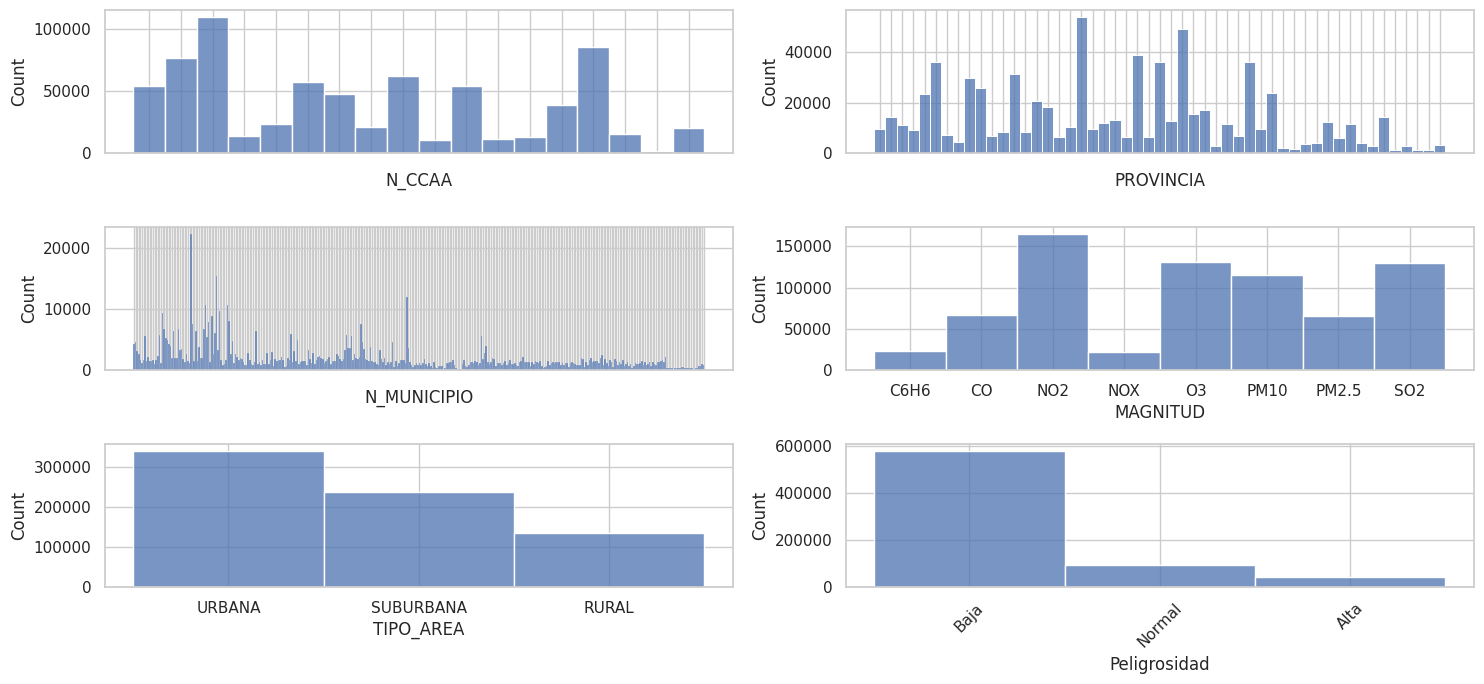

In [90]:
sns.set(style= 'whitegrid')

fig, axis = plt.subplots(3, 2, figsize=(15, 7))

# Histogramas
sns.histplot(ax=axis[0, 0], data=clean_df, x= 'N_CCAA').set_xticklabels([])
sns.histplot(ax=axis[0, 1], data=clean_df, x= 'PROVINCIA').set_xticklabels([])
sns.histplot(ax=axis[1, 0], data=clean_df, x= 'N_MUNICIPIO').set_xticklabels([])
sns.histplot(ax=axis[1, 1], data=clean_df, x= 'MAGNITUD')
sns.histplot(ax=axis[2, 0], data=clean_df, x= 'TIPO_AREA')
sns.histplot(ax=axis[2, 1], data=clean_df, x= 'Peligrosidad')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

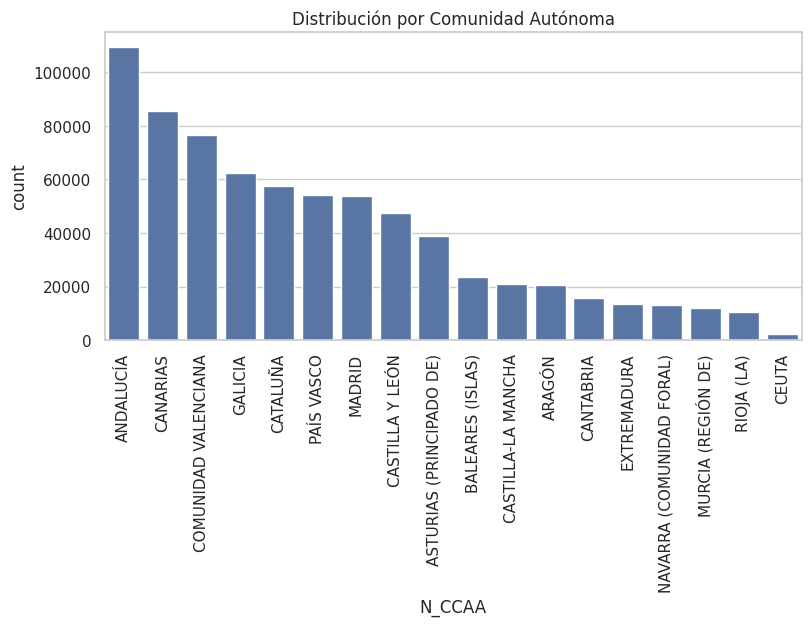

In [91]:
# Distribución de datos en la columna 'N_CCAA', con las Comunidades Autónomas ordenadas por frecuencia en orden descendente en el eje x. 
# Proporciona una visualización de cuántas veces aparece cada provincia en tus datos.
sns.set(style="whitegrid")

plt.figure(figsize=(9, 4))

sns.countplot(data=clean_df, x='N_CCAA', order = clean_df['N_CCAA'].value_counts().index)

plt.title('Distribución por Comunidad Autónoma')
plt.xticks(rotation=90)
plt.show()

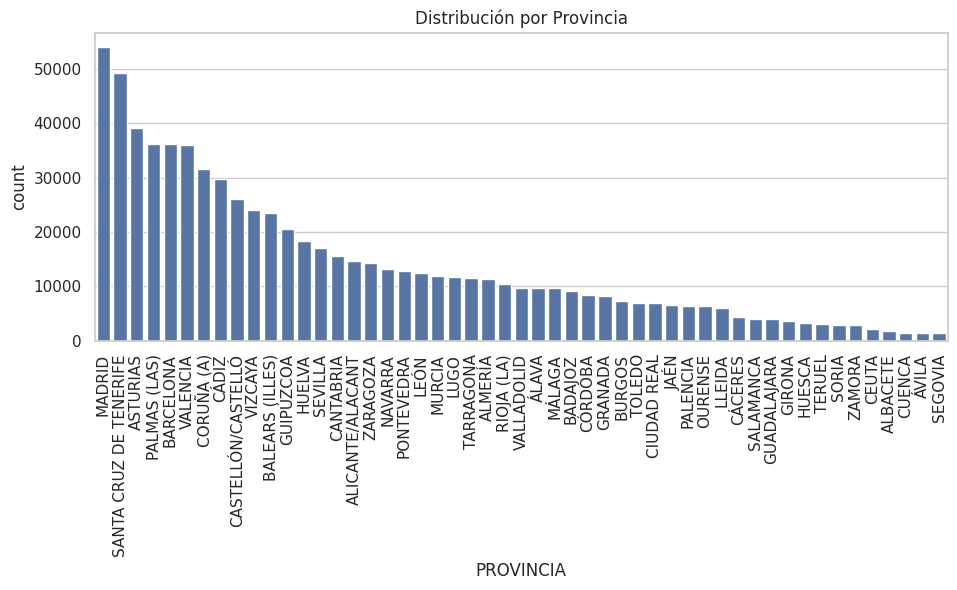

In [92]:
# Distribución de datos en la columna 'PROVINCIA', con las provincias ordenadas por frecuencia en orden descendente en el eje x. 
# Proporciona una visualización de cuántas veces aparece cada provincia en tus datos.
sns.set(style="whitegrid")

plt.figure(figsize=(11, 4))

# Suponiendo que clean_df es tu DataFrame y tiene una columna 'PROVINCIA'
sns.countplot(data=clean_df, x='PROVINCIA', order = clean_df['PROVINCIA'].value_counts().index)

plt.title('Distribución por Provincia')
plt.xticks(rotation=90)
plt.show()

### **3. Analysis multivariate**

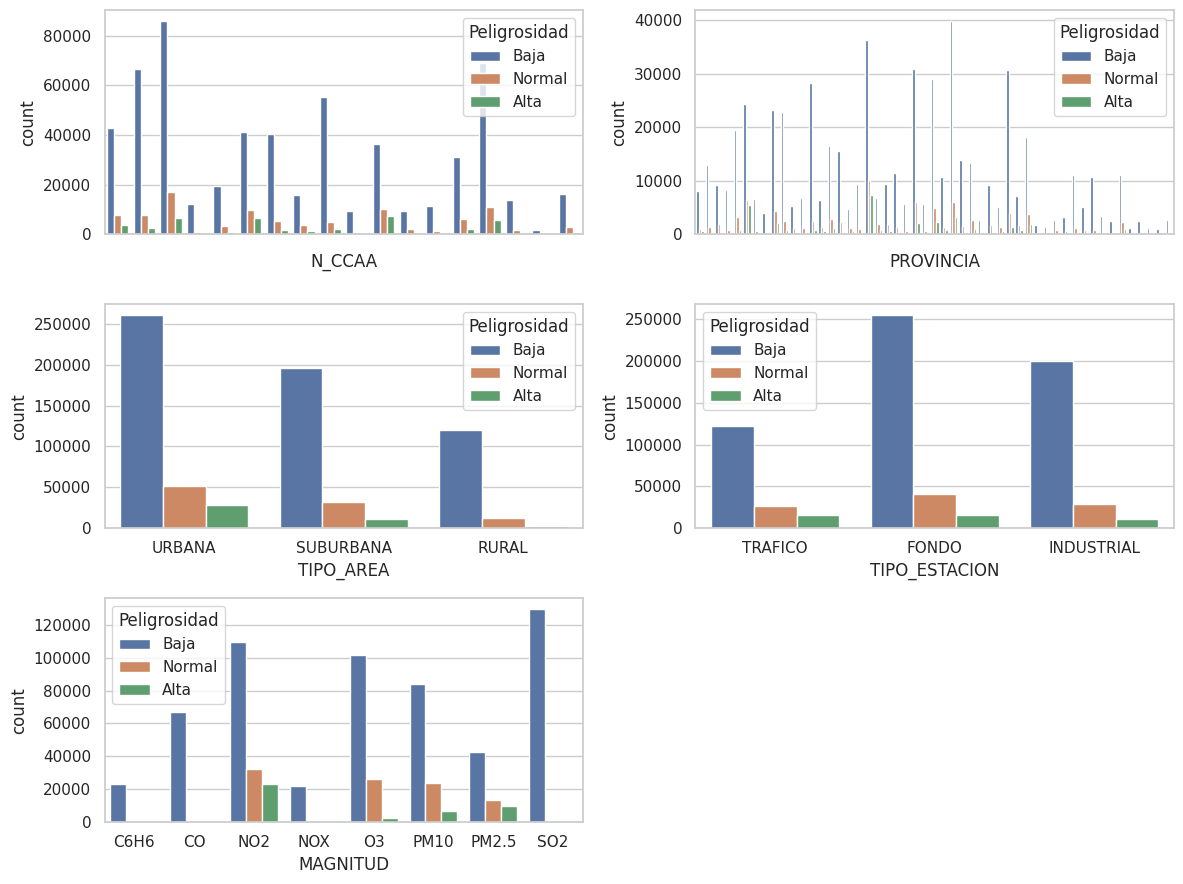

In [93]:
# Análisis Categórico-categórico
fig, axis = plt.subplots(3, 2, figsize = (12, 9))

sns.countplot(ax = axis[0, 0], data = clean_df, x = 'N_CCAA', hue = 'Peligrosidad').set_xticklabels([])
sns.countplot(ax = axis[0, 1], data = clean_df, x = 'PROVINCIA', hue = 'Peligrosidad').set_xticklabels([])
sns.countplot(ax = axis[1, 0], data = clean_df, x = 'TIPO_AREA', hue = 'Peligrosidad')
sns.countplot(ax = axis[1, 1], data = clean_df, x = 'TIPO_ESTACION', hue = 'Peligrosidad')
sns.countplot(ax = axis[2, 0], data = clean_df, x = 'MAGNITUD', hue = 'Peligrosidad')

fig.delaxes(axis[2, 1])

plt.tight_layout()
plt.show()

In [94]:
# Lista de columnas que quieres factorizar
factorize_col = ['N_CCAA', 'PROVINCIA', 'N_MUNICIPIO', 'MAGNITUD', 'TIPO_AREA', 'TIPO_ESTACION', 'Peligrosidad']

# Diccionario para guardar las correspondencias para cada columna
correspondencias = {}

for col in factorize_col:
    # Aplicar pd.factorize a la columna
    labels, unique = pd.factorize(clean_df[col])

    # Actualizar el DataFrame con la columna factorizada
    clean_df[col + '_N'] = labels

    # Guardar la correspondencia en el diccionario usando un rango para representar cada valor único
    correspondencias[col] = dict(zip(unique, range(len(unique))))

# Ahora puedes revisar el DataFrame para confirmar los cambios
clean_df.drop(factorize_col, axis= 1, inplace= True)

In [95]:
# Si quieres ver las correspondencias para una columna específica, por ejemplo, 'N_CCAA'
print("Correspondencia para 'MAGNITUD':", correspondencias['MAGNITUD'])

Correspondencia para 'MAGNITUD': {'C6H6': 0, 'CO': 1, 'NO2': 2, 'NOX': 3, 'O3': 4, 'PM10': 5, 'PM2.5': 6, 'SO2': 7}


In [96]:
# Guardar el diccionario en un archivo .pk
with open('../data/interim/factorize_values.pk', 'wb') as file:
    pickle.dump(correspondencias, file)

In [97]:
save_df = clean_df.to_csv('../data/processed/factorize_df.csv', index= False)

In [98]:
factorize_df = pd.read_csv('../data/processed/factorize_df.csv')

In [99]:
factorize_df.head()

,LATITUD,LONGITUD,Media_Diaria,N_CCAA_N,PROVINCIA_N,N_MUNICIPIO_N,MAGNITUD_N,TIPO_AREA_N,TIPO_ESTACION_N,Peligrosidad_N
0,42.8548,-2.6807,0.187083,0,0,0,0,0,0,0
1,42.8548,-2.6807,0.363333,0,0,0,0,0,0,0
2,42.8548,-2.6807,0.337083,0,0,0,0,0,0,0
3,42.8548,-2.6807,0.281667,0,0,0,0,0,0,0
4,42.8548,-2.6807,0.266250,0,0,0,0,0,0,0


In [102]:
factorize_df.columns

Index(['LATITUD', 'LONGITUD', 'Media_Diaria', 'N_CCAA_N', 'PROVINCIA_N',
       'N_MUNICIPIO_N', 'MAGNITUD_N', 'TIPO_AREA_N', 'TIPO_ESTACION_N',
       'Peligrosidad_N'],
      dtype='object')

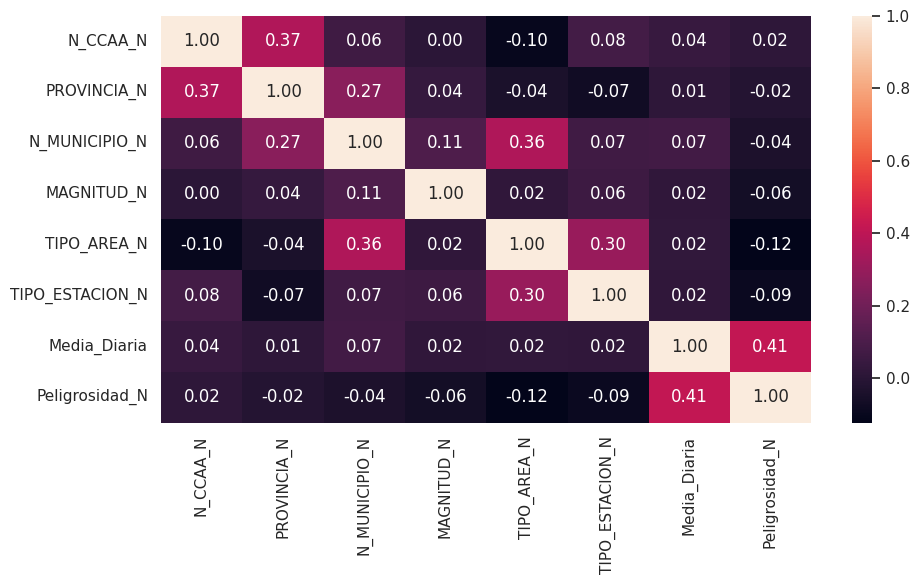

In [103]:
# Correlation map
fig, axis = plt.subplots(figsize = (10, 6))
sns.heatmap(factorize_df[['N_CCAA_N', 'PROVINCIA_N', 'N_MUNICIPIO_N', 'MAGNITUD_N', 'TIPO_AREA_N', 'TIPO_ESTACION_N', 'Media_Diaria', 'Peligrosidad_N']].corr(), annot = True, fmt = ".2f")

plt.tight_layout()
plt.show()